In [35]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ray.train import Checkpoint, session
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

In [36]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [37]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [44]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda:0")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr= config["lr"], momentum= config["momentum"])
    for i in range(10):
        train_func(model, optimizer, train_loader)
        acc = test_func(model, test_loader)

        checkpoint = train.get_checkpoint()
        # Send the current training result back to Tune
        train.report({"mean_accuracy": acc}, checkpoint= checkpoint)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")


In [59]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)


results = tuner.fit()

2023-12-19 12:38:59,496	INFO tune.py:1047 -- Total run time: 5.17 seconds (5.15 seconds for the tuning loop).


In [63]:
results.get_dataframe(filter_metric='mean_accuracy', filter_mode='max')

,mean_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/lr,config/momentum,logdir
0,0.175,1702985938,None,False,2,303d4_00000,2023-12-19_12-38-58,0.070514,3.102434,143089,calatrava-Stealth-GS66-12UH,192.168.100.149,3.102434,2,3.029161e-09,0.275639,303d4_00000


[<Axes: >]

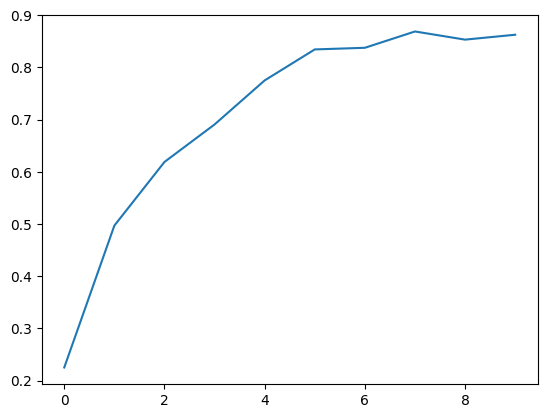

In [53]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

In [54]:
results

ResultGrid<[
  Result(
    metrics={'mean_accuracy': 0.8625},
    path='/home/calatrava/ray_results/train_mnist_2023-12-19_12-28-03/train_mnist_ac930_00000_0_momentum=0.8246_2023-12-19_12-28-03',
    filesystem='local',
    checkpoint=None
  )
]>

In [75]:
10 ** (-10 * np.random.rand())

7.412562391513864e-07